In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as np
from jax.numpy.fft import rfft2, irfft2, rfftfreq, fftfreq, rfft, irfft
from jax.scipy.integrate import trapezoid
from scipy.integrate import RK45
import matplotlib.pyplot as plt
import numpy as onp

In [2]:
def gaussian(v):
    return np.exp(-0.5*v**2)/np.sqrt(2*np.pi)

def f0(x,v):
    x = x[:,None]
    return gaussian(v) * (1 + 0.5 * np.cos(2*np.pi*x))

In [3]:
Nx, Nv = 128, 2048
N = (Nx, Nv+1)
X = 0.5
V = 2*np.pi
T = 1.5

x = np.linspace(-X, X, Nx+1)[1:]
v = np.linspace(-V, V, Nv+1)
f0 = f0(x,v)

2024-01-12 13:19:43.525483: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
freq_x = fftfreq(Nx, 2*X/Nx)
x_ik2pi = 2j * np.pi * freq_x
x_i2pik = 2j * np.pi * rfftfreq(Nx, 2*X/Nv)
freq_v = rfftfreq(Nv, 2*V/Nv)
v_ik2pi = 2j * np.pi * freq_v

In [5]:
f0hat = rfft2(f0)
shape = f0hat.shape

def compute_E(f):
    rho = np.maximum(trapezoid(f, dx=2*V/Nv, axis=-1), 1e-8)
    m = rho.mean(-1)
    Ehat = np.hstack([0, rfft(rho-m)[1:] / x_i2pik[1:]])
    E = irfft(Ehat, Nx)
    return E

@jax.jit
def eqn(t, fhat):
    fhat = fhat.reshape(shape)
    f = irfft2(fhat, N)
    transport_x = - x_ik2pi[:,None] * rfft2(f * v)
    E = compute_E(f)
    transport_v = - v_ik2pi * rfft2(f * E[:,None])
    return (transport_x + transport_v).ravel()

In [6]:
f0hat = f0hat.flatten()
solver = RK45(eqn, t0=0., y0=f0hat, t_bound=T)
t, fhat = [0.], [f0hat]

while solver.status == 'running':
    solver.step()
    t.append(solver.t)
    fhat.append(solver.y)

In [29]:
def drawing(index):
    f = irfft2(fhat[index].reshape(shape), N)
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9, 4))
    im = ax0.imshow(f.T, origin='lower', aspect='auto', cmap='jet')
    ax0.set_title(f"Strong landau damping, time: {t[index]:.3e}")
    ax0.set_axis_off()
    plt.colorbar(im)
    rho = trapezoid(f, dx=2*V/Nv, axis=-1)
    ax1.plot(x, rho, label=r"$\rho$")
    ax1.set_xlabel(r"$x$")
    ax1.set_title(f"time: {t[index]:.3e}, mass:{rho.mean():.3e}")
    ax1.legend()
    plt.tight_layout()
    plt.show()

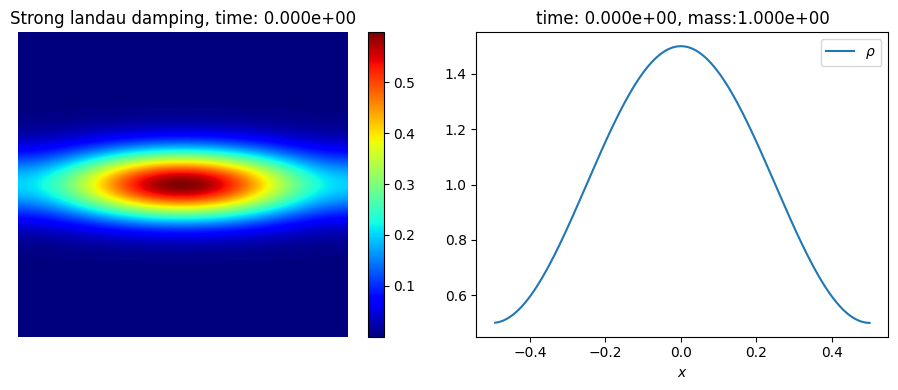

In [30]:
drawing(0)

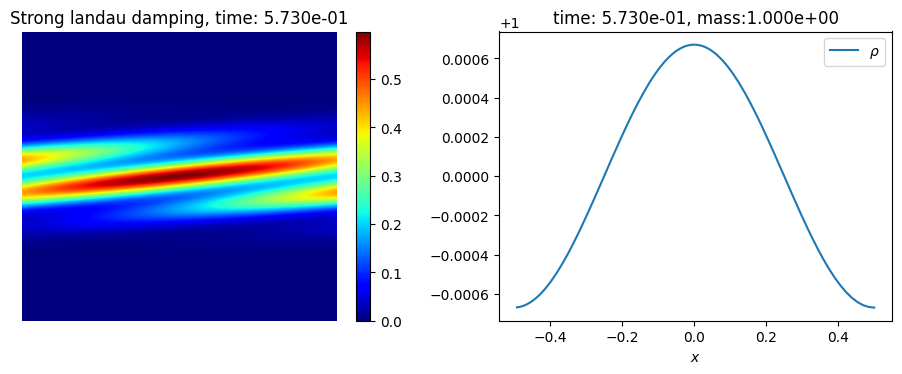

In [31]:
drawing(900)

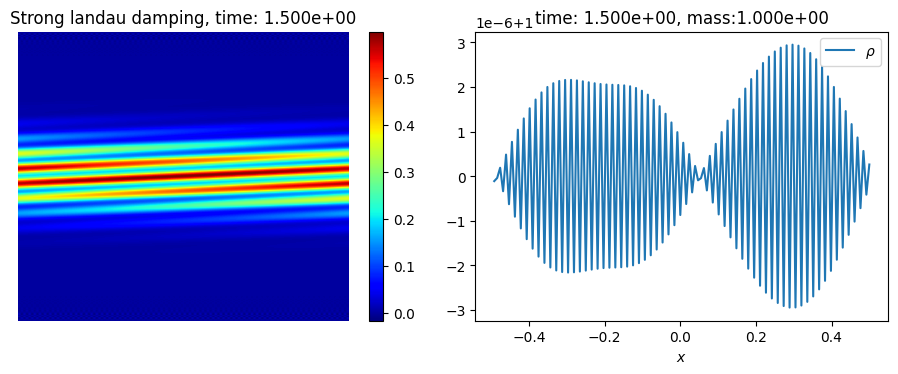

In [34]:
drawing(-1)

In [12]:
file = onp.asarray([t[-1], fhat[-1]], dtype="object")
onp.save("strong_damping.npy", file)
#t, fhat = np.load("strong_damping.npy", allow_pickle=True)